In [1]:
import pandas as pd 
import janitor

def get_data():
    URL_CSV="https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
    df = pd.read_csv(URL_CSV)
    df['Country/Region'] = df['Country/Region'].replace({'US':'United States of America'})
    return df
df = get_data()
df

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,9/21/20,9/22/20,9/23/20,9/24/20,9/25/20,9/26/20,9/27/20,9/28/20,9/29/20,9/30/20
0,NaN,Afghanistan,33.939110,67.709953,0,0,0,0,0,0,...,39074,39096,39145,39170,39186,39192,39227,39233,39254,39268
1,NaN,Albania,41.153300,20.168300,0,0,0,0,0,0,...,12535,12666,12787,12921,13045,13153,13259,13391,13518,13649
2,NaN,Algeria,28.033900,1.659600,0,0,0,0,0,0,...,50023,50214,50400,50579,50754,50914,51067,51213,51368,51530
3,NaN,Andorra,42.506300,1.521800,0,0,0,0,0,0,...,1681,1681,1753,1753,1836,1836,1836,1966,1966,2050
4,NaN,Angola,-11.202700,17.873900,0,0,0,0,0,0,...,4117,4236,4363,4475,4590,4672,4718,4797,4905,4972
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,NaN,West Bank and Gaza,31.952200,35.233200,0,0,0,0,0,0,...,36151,36580,37083,37591,37963,38253,38703,39121,39541,39899
262,NaN,Western Sahara,24.215500,-12.885800,0,0,0,0,0,0,...,10,10,10,10,10,10,10,10,10,10
263,NaN,Yemen,15.552727,48.516388,0,0,0,0,0,0,...,2028,2028,2029,2029,2029,2030,2030,2031,2031,2034
264,NaN,Zambia,-13.133897,27.849332,0,0,0,0,0,0,...,14175,14389,14443,14491,14515,14612,14641,14660,14715,14759


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
2,2020-01-24,-4.744451e+03,0.000000e+00,8.721731e+04,-4.744451e+03,-4.744451e+03,15410.118984,15410.118984,15410.118984,15410.118984,15410.118984,15410.118984,0.0,0.0,0.0,1.066567e+04
3,2020-01-25,-1.810622e+03,0.000000e+00,9.154862e+04,-1.810622e+03,-1.810622e+03,16056.577999,16056.577999,16056.577999,16056.577999,16056.577999,16056.577999,0.0,0.0,0.0,1.424596e+04
4,2020-01-26,1.123206e+03,0.000000e+00,7.563870e+04,1.123206e+03,1.123206e+03,-385.191924,-385.191924,-385.191924,-385.191924,-385.191924,-385.191924,0.0,0.0,0.0,7.380145e+02
7,2020-01-29,9.924692e+03,0.000000e+00,7.701184e+04,9.924692e+03,9.924692e+03,-4908.486558,-4908.486558,-4908.486558,-4908.486558,-4908.486558,-4908.486558,0.0,0.0,0.0,5.016206e+03
8,2020-01-30,1.285852e+04,0.000000e+00,8.543968e+04,1.285852e+04,1.285852e+04,1037.978258,1037.978258,1037.978258,1037.978258,1037.978258,1037.978258,0.0,0.0,0.0,1.389650e+04
9,2020-01-31,1.579373e+04,0.000000e+00,1.041540e+05,1.579373e+04,1.579373e+04,15410.118984,15410.118984,15410.118984,15410.118984,15410.118984,15410.118984,0.0,0.0,0.0,3.120385e+04
10,2020-02-01,1.872894e+04,0.000000e+00,1.131752e+05,1.872894e+04,1.872894e+04,16056.577999,16056.577999,16056.577999,16056.577999,16056.577999,16056.577999,0.0,0.0,0.0,3.478552e+04
11,2020-02-02,2.166416e+04,0.000000e+00,1.006588e+05,2.166416e+04,2.166416e+04,-385.191924,-385.191924,-385.191924,-385.191924,-385.191924,-385.191924,0.0,0.0,0.0,2.127896e+04
12,2020-02-03,2.459937e+04,0.000000e+00,9.023059e+04,2.459937e+04,2.459937e+04,-12740.338073,-12740.338073,-12740.338073,-12740.338073,-12740.338073,-12740.338073,0.0,0.0,0.0,1.185903e+04
13,2020-02-04,2.753458e+04,0.000000e+00,8.690825e+04,2.753458e+04,2.753458e+04,-14470.658686,-14470.658686,-14470.658686,-14470.658686,-14470.658686,-14470.658686,0.0,0.0,0.0,1.306392e+04


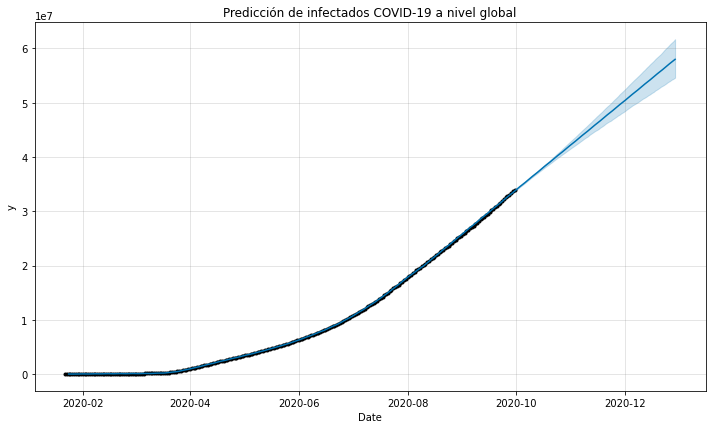

In [2]:
import janitor
import pandas as pd
import pandas_flavor as pf
import fbprophet
from matplotlib import pyplot as plt    
from IPython.display import display, HTML



LISTA_COLUMNAS_A_BORRAR = ['Province/State', 'Country/Region', 'Lat', 'Long']



df = get_data()
df = df.remove_columns(LISTA_COLUMNAS_A_BORRAR)
df
df = pd.DataFrame( df.sum())
df.columns=['y']
df.index = pd.to_datetime(df.index)  
df['ds'] = df.index
df = df.reset_index()


df = df.remove_columns(['index'])


df_prophet = fbprophet.Prophet(changepoint_prior_scale=0.15)
df_prophet.fit(df)

df_forecast = df_prophet.make_future_dataframe(periods=90, freq='D')
# Make predictions
df_forecast = df_prophet.predict(df_forecast)
df_forecast

df_forecast = df_forecast[df_forecast["yhat"] >= 0]
df_forecast.loc[df_forecast.yhat_lower < 0, 'yhat_lower'] = 0


df_prophet.plot(df_forecast, xlabel = 'Date' )
plt.title('Predicción de infectados COVID-19 a nivel global'   )

display(HTML(pd.DataFrame(df_forecast).to_html()))


In [3]:
df = get_data()
df

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,9/21/20,9/22/20,9/23/20,9/24/20,9/25/20,9/26/20,9/27/20,9/28/20,9/29/20,9/30/20
0,NaN,Afghanistan,33.939110,67.709953,0,0,0,0,0,0,...,39074,39096,39145,39170,39186,39192,39227,39233,39254,39268
1,NaN,Albania,41.153300,20.168300,0,0,0,0,0,0,...,12535,12666,12787,12921,13045,13153,13259,13391,13518,13649
2,NaN,Algeria,28.033900,1.659600,0,0,0,0,0,0,...,50023,50214,50400,50579,50754,50914,51067,51213,51368,51530
3,NaN,Andorra,42.506300,1.521800,0,0,0,0,0,0,...,1681,1681,1753,1753,1836,1836,1836,1966,1966,2050
4,NaN,Angola,-11.202700,17.873900,0,0,0,0,0,0,...,4117,4236,4363,4475,4590,4672,4718,4797,4905,4972
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,NaN,West Bank and Gaza,31.952200,35.233200,0,0,0,0,0,0,...,36151,36580,37083,37591,37963,38253,38703,39121,39541,39899
262,NaN,Western Sahara,24.215500,-12.885800,0,0,0,0,0,0,...,10,10,10,10,10,10,10,10,10,10
263,NaN,Yemen,15.552727,48.516388,0,0,0,0,0,0,...,2028,2028,2029,2029,2029,2030,2030,2031,2031,2034
264,NaN,Zambia,-13.133897,27.849332,0,0,0,0,0,0,...,14175,14389,14443,14491,14515,14612,14641,14660,14715,14759


In [4]:

import janitor
import datetime
import numpy as np

def pipeline_populations():
    """ Cogemos un dataframe de poblaciones"""

    URL="https://population.un.org/wpp/Download/Files/1_Indicators%20(Standard)/CSV_FILES/WPP2019_TotalPopulationBySex.csv"
    THIS_YEAR = datetime.datetime.now().year

    return (
        pd.read_csv(URL)
        .filter_on( f""" Time  ==  {THIS_YEAR} & Variant == "Medium" """ ) 
        .select_columns(['Location','PopTotal'])
        .join_apply(lambda x: x['PopTotal'] * 1000 , new_column_name="PopMillions" )
        .remove_columns(['PopTotal'])
        .rename_column('PopMillions' , 'PopTotal')
        .transform_column('PopTotal',np.int64)
        .rename_column('Location' , 'Country/Region')
    )


populations = pipeline_populations()
populations

,Country/Region,PopTotal
70,Afghanistan,38928341
954,Africa,1340598113
1838,African Group,1338826591
1989,African Union,1339423920
2140,African Union: Central Africa,158619638
...,...,...
277315,World,7794798728
278199,World Bank Regional Groups (developing only),6528762227
278350,Yemen,29825967
279234,Zambia,18383956


In [5]:
df = get_data()
df_country = pd.DataFrame()
df_country['Country/Region'] = df['Country/Region']
df_country['infected last_day'] = df.iloc[:,-1] - df.iloc[:,-2]
df_country.set_index('Country/Region')
df_country

,Country/Region,infected last_day
0,Afghanistan,14
1,Albania,131
2,Algeria,162
3,Andorra,84
4,Angola,67
...,...,...
261,West Bank and Gaza,358
262,Western Sahara,0
263,Yemen,3
264,Zambia,44


In [6]:
df_country_enrich = pd.merge(df_country, populations, on="Country/Region")
df_country_enrich['Infected/Million'] =  1000000 * df_country_enrich['infected last_day'] / df_country_enrich['PopTotal'] 
df_country = df_country_enrich

In [7]:
df_country.sort_values(by='Infected/Million', ascending=False).head(10)

,Country/Region,infected last_day,PopTotal,Infected/Million
3,Andorra,84,77265,1087.167540
140,Israel,8568,8655541,989.886132
18,Bahamas,220,393248,559.443405
212,Spain,20922,46754782,447.483639
6,Argentina,14392,45195777,318.436831
168,Montenegro,197,628062,313.663301
19,Bahrain,442,1701582,259.758272
24,Belize,101,397621,254.010729
88,Costa Rica,1156,5094114,226.928569
33,Cabo Verde,124,555988,223.026396


In [8]:
from datetime import datetime, timedelta
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.dates as mdates


def pintar_grafico(df, array_naciones_pintar ,title):
    df = df.T
    df = df.iloc[1:]
    new_header = df.iloc[0] #grab the first row for the header
    df = df[1:] #take the data less the header row
    df.columns = new_header #set the header row as the df header
    df = df.iloc[2:]
    df.index = pd.to_datetime(df.index)
    df = df[array_naciones_pintar]
    df = df.iloc[:, : 9]
    chart_df = df

    pd.plotting.register_matplotlib_converters()
    chart_df.plot(legend=True,figsize=(13.5,9))

    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%B-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=15))
    plt.xticks(rotation=45)

    ax = plt.gca()

    ax.set_title(title)
    ax.set_ylim(ymin=0)

    plt.show()

    #df.tail(30).style.format ({ c : "{:20,.0f}" for c in df.columns }).background_gradient(cmap='Wistia', )
    return plt 



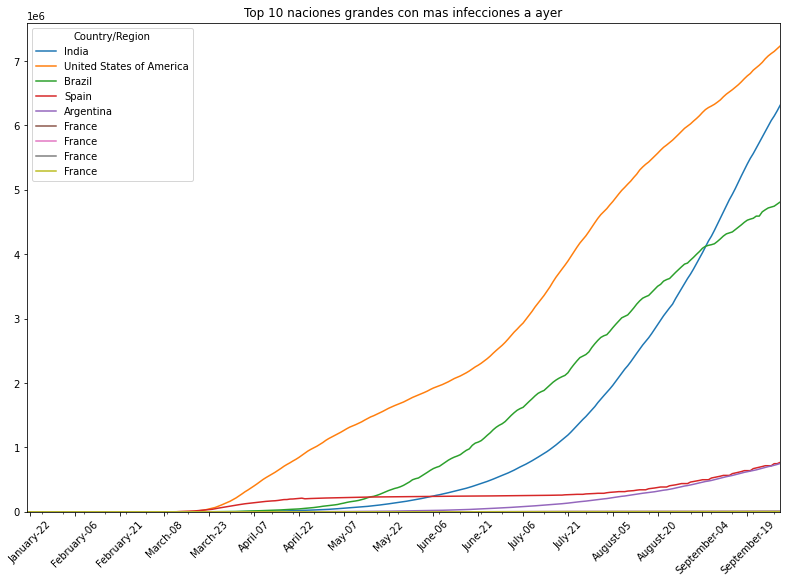

<module 'matplotlib.pyplot' from '/root/anaconda2/envs/jupyter/lib/python3.6/site-packages/matplotlib/pyplot.py'>

In [9]:
title="Top 10 naciones grandes con mas infecciones a ayer"
display(HTML(f"""<h1 id='{title}'>{title}</h1>"""))
df = get_data()

naciones_pintar = df_country.sort_values(by='infected last_day', ascending=False).head(10)['Country/Region'].values
df_country.sort_values(by='infected last_day', ascending=False).head(10)

pintar_grafico(df,naciones_pintar,title)



In [10]:
def pintar_grafico_daily(df, array_naciones_pintar ,title):
    df = df.T
    df = df.iloc[1:]
    new_header = df.iloc[0] #grab the first row for the header
    df = df[1:] #take the data less the header row
    df.columns = new_header #set the header row as the df header
    df = df.iloc[2:]
    df.index = pd.to_datetime(df.index)
    df = df[array_naciones_pintar]
    chart_df = df

    pd.plotting.register_matplotlib_converters()
    
    df_daily_increments = pd.DataFrame()
    for country in chart_df.columns:
        df_daily_increments[country] = chart_df[country].pct_change().rolling(window=7).mean()

    df_daily_increments    

    chart_df = df_daily_increments
    chart_df.tail(45).plot(legend=True,figsize=(13.5,9))

    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%B-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=15))
    plt.xticks(rotation=45)

    ax = plt.gca()

    ax.set_title(title)
    ax.set_ylim(ymin=0)

    plt.show()

    chart_df.tail(30).style.format ({ c : "{:20,.2f}" for c in df.columns }).background_gradient(cmap='Wistia', )


    return chart_df


#pintar_grafico_daily(df,naciones_pintar,"Top 10 countries more cases, daily percentage change")
df_country

,Country/Region,infected last_day,PopTotal,Infected/Million
0,Afghanistan,14,38928341,0.359635
1,Albania,131,2877800,45.520884
2,Algeria,162,43851043,3.694325
3,Andorra,84,77265,1087.167540
4,Angola,67,32866267,2.038564
...,...,...,...,...
241,Uzbekistan,363,33469199,10.845793
242,Western Sahara,0,597330,0.000000
243,Yemen,3,29825967,0.100583
244,Zambia,44,18383956,2.393391


In [11]:
#pintar_grafico_daily(df,naciones_pintar,"Top 10 countries more cases, daily percentage change")